In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import spatial
import inputs

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

In [2]:
res = dd.io.load(cfg.netfile.format(net=demonstrator['net']))
X, Y, W = res['X']*meter, res['Y']*meter, res['W']
stimulated_neurons = res['stimulated_neurons']
W[np.isnan(W)] = 0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)

In [3]:
def get_distance_to_stim(stimid):
    Wb = W>0
    d = np.zeros_like(X, int)
    d[res['stimulated_neurons'][stimid]] = 1
    for i in range(2, 10):
        pre = (d == i-1) & (np.arange(len(d)) < cfg.params['N_exc'])
        post = np.unique(np.nonzero(Wb[pre])[1])
        added = False
        for p in post:
            if d[p] == 0:
                d[p] = i
                added = True
        if np.sum(d==0) == 0:
            dmax = i
            break
        elif not added:
            dmax = i-1
    d -= 1
    return d, dmax

In [4]:
dA, dA_max = get_distance_to_stim(cfg.stimuli['A'])
dB, dB_max = get_distance_to_stim(cfg.stimuli['B'])
dmax = max(dA_max, dB_max) - 1

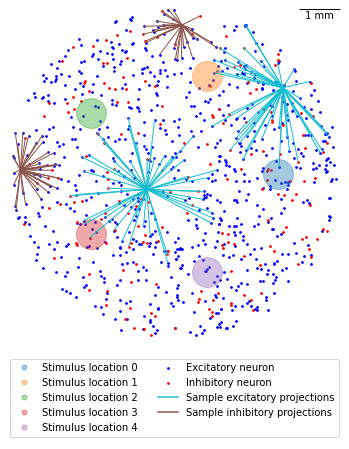

In [5]:
fig, ax = plt.subplots(figsize=(6,8))

for coords in zip(Xstim, Ystim):
    plt.plot(*coords, 'o', ms=30, alpha=.4)
ax.set_prop_cycle(None)
for label in range(5):
    plt.plot([], 'o', ms=5, alpha=.4, label=f'Stimulus location {label}')

plt.scatter(X[:cfg.params['N_exc']], Y[:cfg.params['N_exc']], s=3, c='b', label='Excitatory neuron')
plt.scatter(X[cfg.params['N_exc']:], Y[cfg.params['N_exc']:], s=3, c='r', label='Inhibitory neuron')
for i in (0, 17):
    for j in np.flatnonzero(W[i]):
        plt.plot((X[i], X[j]), (Y[i], Y[j]), c='C9', lw=1)
for i in (903,908):
    for j in np.flatnonzero(W[i]):
        plt.plot((X[i], X[j]), (Y[i], Y[j]), c='C5', lw=1)
plt.plot([], c='C9', label='Sample excitatory projections')
plt.plot([], c='C5', label='Sample inhibitory projections')

ax.add_artist(AnchoredSizeBar(ax.transData, 1*mm, '1 mm', 'upper right', frameon=False))

plt.legend(loc='lower center', ncol=2)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-6.5*mm, 4.05*mm)
ax.set_xlim(-4.05*mm, 4.05*mm)
sns.despine(left=True, bottom=True)

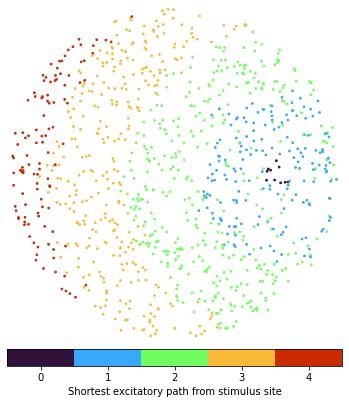

In [16]:
fig, ax = plt.subplots(figsize=(6,7))
m = ax.scatter(X, Y, c=dA, s=3, cmap='turbo', vmax=dA_max-.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-4.05*mm, 4.05*mm)
ax.set_ylim(-4.05*mm, 4.05*mm)
plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.02, fraction=.1, values=range(dA_max), label='Shortest excitatory path from stimulus site')
sns.despine(left=True, bottom=True)